In [ ]:
import pandas as pd
import sqlite3

def export_db_table_to_csv(db_name: str, table_name: str):
    # Connect to the SQLite database
    # Replace 'path_to_your_db.db' with your actual database file path
    conn = sqlite3.connect(db_name)

    # Query the database and load into a pandas DataFrame
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)

    # Export to CSV
    df.to_csv(f'{table_name}.csv', index=False)

    # Close the connection
    conn.close()

# export_db_table_to_csv('20250122_215428.db', 'follows')
# export_db_table_to_csv('20250122_215428.db', 'posts')
# export_db_table_to_csv('20250122_215428.db', 'users')
# export_db_table_to_csv('20250122_215428.db', 'comments')
# export_db_table_to_csv('20250122_215428.db', 'user_actions')

In [4]:
import sqlite3
import json

def get_db_schema_as_sql(db_name: str):
    """
    Extract the schema from a SQLite database as CREATE TABLE SQL statements.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect(db_name)
    
    # Create a cursor object
    cursor = conn.cursor()
    
    # Get all table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    schema_sql = {}
    
    for table in tables:
        table_name = table[0]
        # Get the CREATE TABLE statement for this table
        cursor.execute(f"SELECT sql FROM sqlite_master WHERE type='table' AND name='{table_name}';")
        create_statement = cursor.fetchone()[0]
        schema_sql[table_name] = create_statement
    
    # Close the connection
    conn.close()
    
    return schema_sql

# Example usage
db_schema_sql = get_db_schema_as_sql('20250122_215428.db')

# Print the SQL statements
for table_name, create_statement in db_schema_sql.items():
    print(f"-- Table: {table_name}")
    print(f"{create_statement};")
    print()

# Save the SQL schema to a file
with open('db_schema.sql', 'w') as f:
    for table_name, create_statement in db_schema_sql.items():
        f.write(f"-- Table: {table_name}\n")
        f.write(f"{create_statement};\n\n")

# Also save as JSON if needed
with open('db_schema.json', 'w') as f:
    json.dump(db_schema_sql, f, indent=4)

-- Table: users
CREATE TABLE users (
                    user_id TEXT PRIMARY KEY,
                    persona TEXT,
                    background_labels JSON,
                    creation_time DATETIME DEFAULT CURRENT_TIMESTAMP,
                    follower_count INTEGER DEFAULT 0,
                    total_likes_received INTEGER DEFAULT 0,
                    total_shares_received INTEGER DEFAULT 0,
                    total_comments_received INTEGER DEFAULT 0,
                    influence_score FLOAT DEFAULT 0.0,
                    is_influencer BOOLEAN DEFAULT FALSE,
                    last_influence_update TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                );

-- Table: posts
CREATE TABLE posts (
                    post_id TEXT PRIMARY KEY,
                    content TEXT NOT NULL,
                    author_id TEXT NOT NULL,
                    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    num_likes INTEGER DEFAULT 0,
                    num_shares IN

Top 50 Users by Engagement:
        user_id                                            persona  \
1   user-1d4bfd  You are a 32 year old female who grew up in a ...   
2   user-42bd51  You are a 36 year old female who grew up in a ...   
3   user-9b5856  You are a 24 year old male who grew up in a su...   
4   user-ded255  You are a 43 year old male who grew up in a sm...   
5   user-e6fc13  You are a 34 year old female who grew up in a ...   
..          ...                                                ...   
65  user-27b16c  You are a 21 year old male who grew up in a ur...   
66  user-5e4bf2  You are a 30 year old female who grew up in a ...   
67  user-2896b5  You are a 30 year old male who grew up in a sm...   
68  user-d9295c  You are a 21 year old male who grew up in a ur...   
69  user-589c12  You are a 44 year old male who grew up in a ru...   

    follower_count  total_likes_received  total_shares_received  \
1               25                    44                      2 

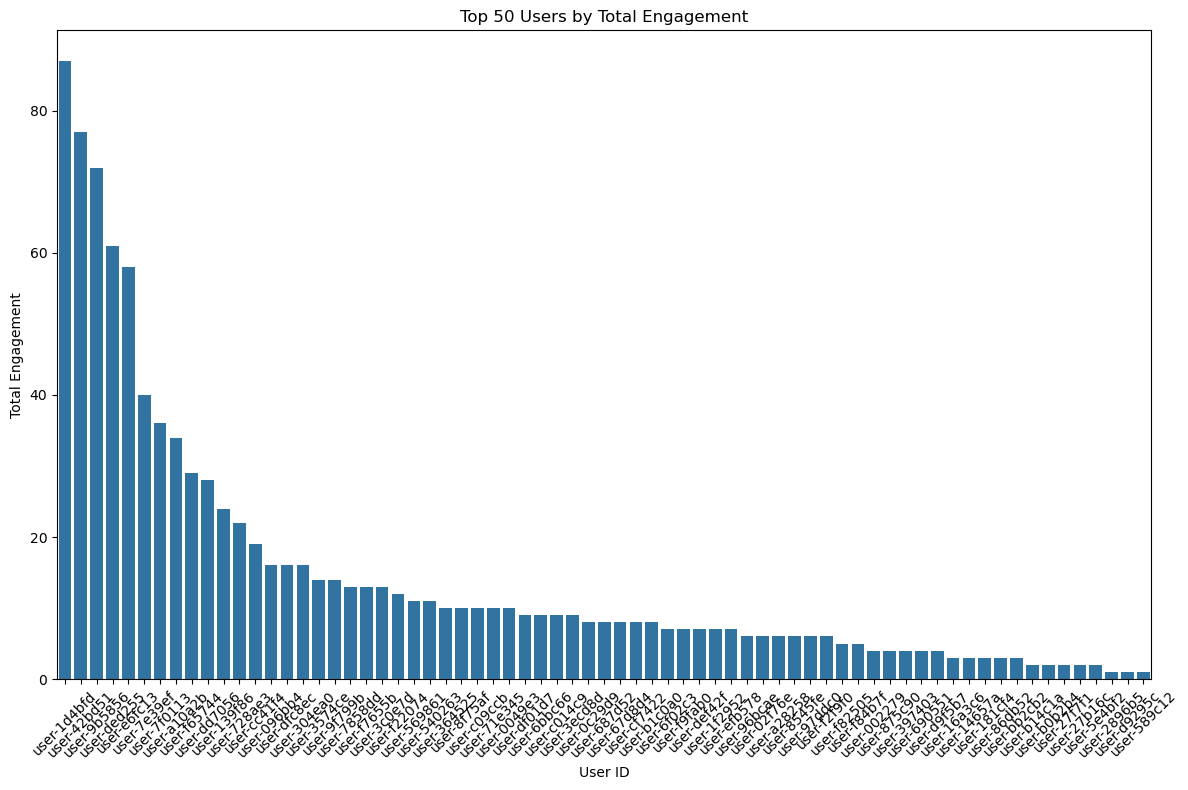

In [10]:
import pandas as pd
import sqlite3

def get_top_users_by_engagement(db_name, n=10):
    """
    Get the top n users with highest engagement metrics.
    Engagement is calculated as the sum of follower_count, total_likes_received,
    total_shares_received, and total_comments_received.
    """
    conn = sqlite3.connect(db_name)
    
    query = """
    SELECT 
        user_id, 
        persona,
        follower_count,
        total_likes_received,
        total_shares_received,
        total_comments_received,
        (follower_count + total_likes_received + total_shares_received + total_comments_received) as total_engagement
    FROM users
    ORDER BY total_engagement DESC
    LIMIT ?
    """
    
    df = pd.read_sql_query(query, conn, params=(n,))
    conn.close()
    
    return df

# Get top users by engagement
top_users = get_top_users_by_engagement('20250122_215428.db', 70)

# exclude "agentverse_news"
top_users = top_users[top_users['user_id'] != 'agentverse_news']

# Display the results
print("Top 50 Users by Engagement:")
print(top_users)

# Save to CSV if needed
top_users.to_csv('top_users_by_engagement.csv', index=False)

# You can also create a visualization if you want
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='user_id', y='total_engagement', data=top_users)
plt.title('Top 50 Users by Total Engagement')
plt.xlabel('User ID')
plt.ylabel('Total Engagement')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_users_engagement.png')
plt.show()

Top 10 Users by Engagement and Their Background Labels:
1. User ID: user-1d4bfd
   Persona: You are a 32 year old female who grew up in a small town area. You spend most of your time on relaxing. The value most important to you is integrity. Your closest friend or family member is outgoing. In unfamiliar social contexts, you are typically awkward. With infinite money, you would spend most time helping others. Your favorite hobby is movies. Your political affiliation is apolitical. You have lived in 2-3 places. In social relationships, fun is most important to you. Your childhood was difficult. Your MBTI type is ESTJ. Your primary goal for the next 5 years is family. You fear failure the most. You have not experienced childhood trauma that affects you today. You occasionally experience intrusive thoughts. One of the most meaningful events in your life was birth of a child. You have experienced tension growing up between different cultural norms. When solving difficult situations, your p

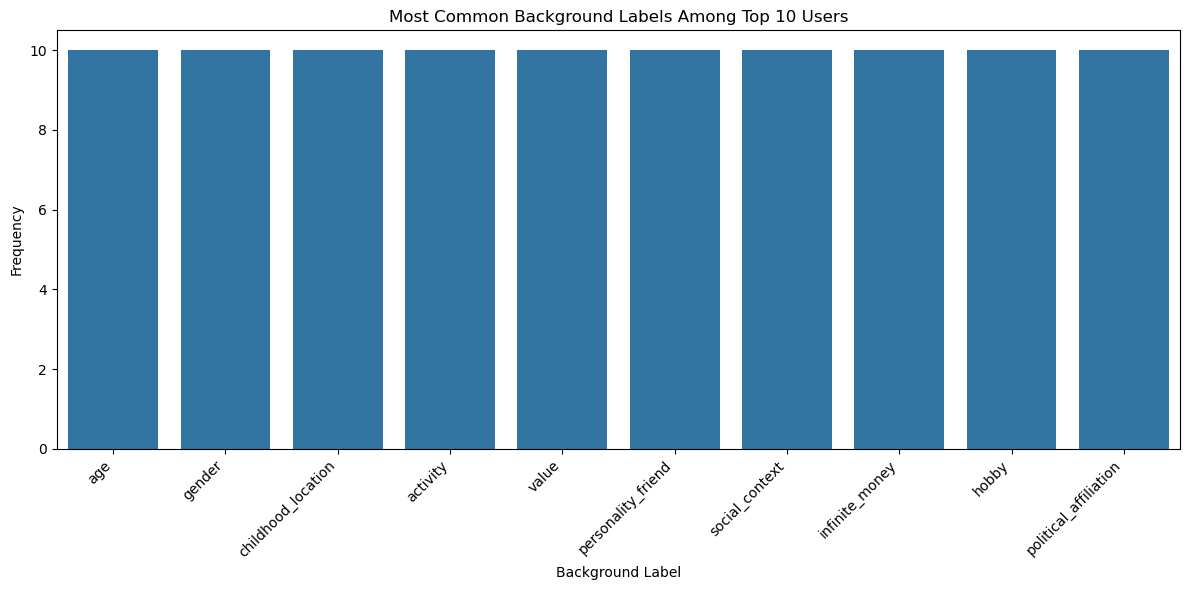

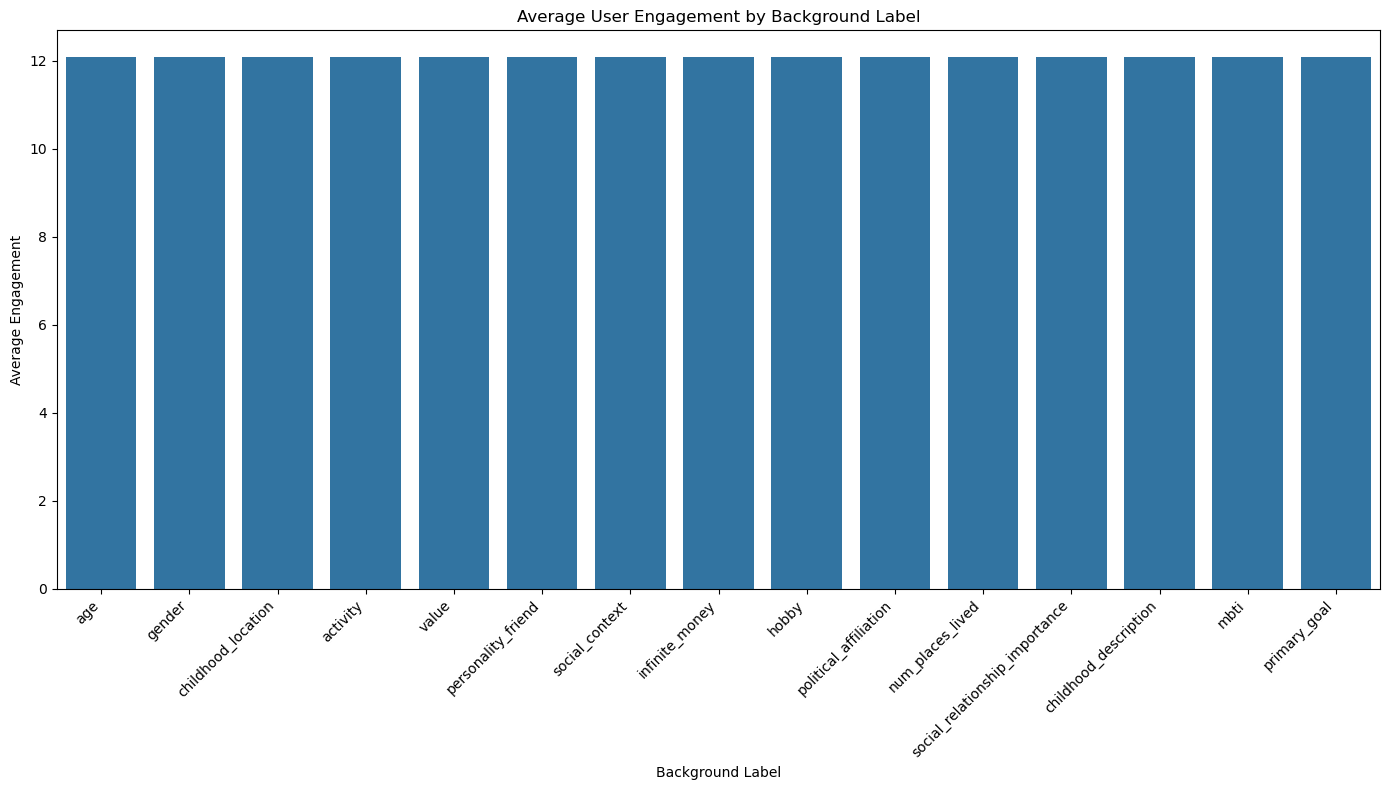

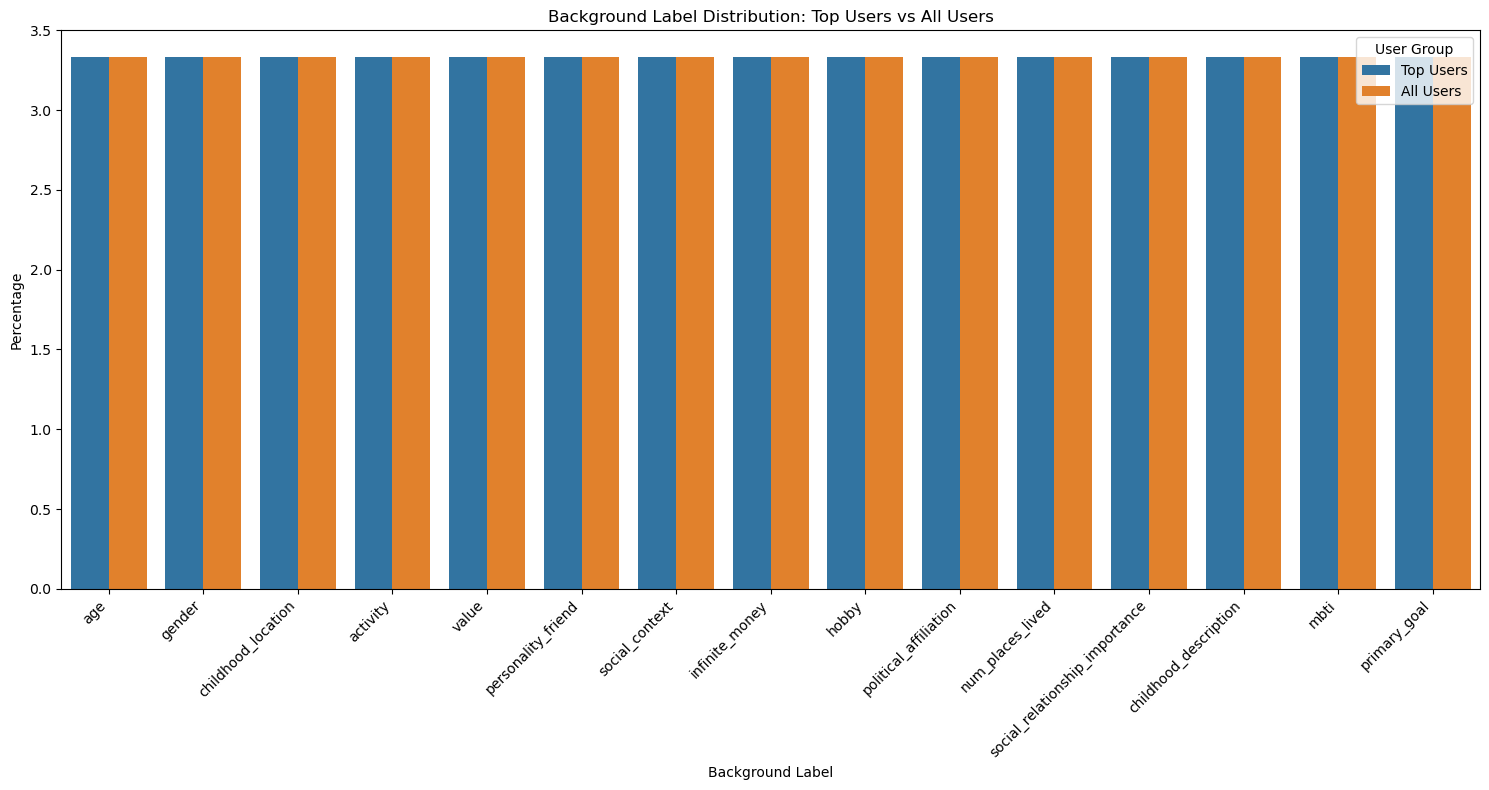

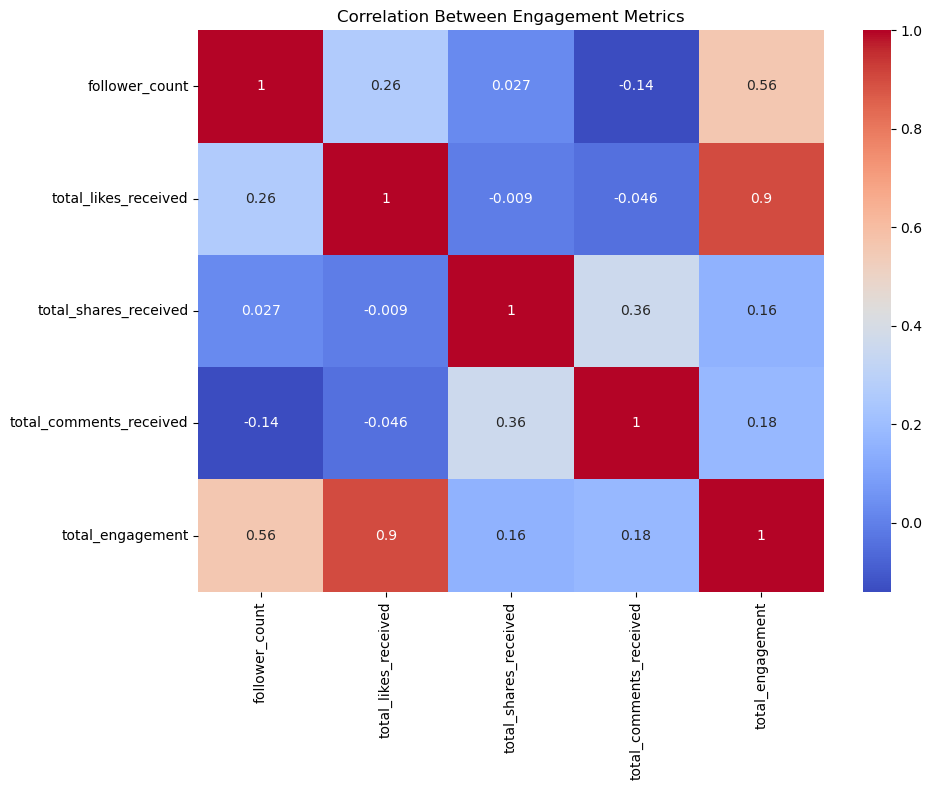

In [11]:
import pandas as pd
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def analyze_background_labels_and_engagement(db_name, n=10):
    """
    Analyze the relationship between user background labels and engagement metrics.
    """
    conn = sqlite3.connect(db_name)
    
    # Get top users by engagement and their background labels
    query = """
    SELECT 
        user_id, 
        persona,
        background_labels,
        follower_count,
        total_likes_received,
        total_shares_received,
        total_comments_received,
        (follower_count + total_likes_received + total_shares_received + total_comments_received) as total_engagement
    FROM users
    WHERE user_id != 'agentverse_news'
    ORDER BY total_engagement DESC
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    # Parse the JSON background_labels
    df['parsed_labels'] = df['background_labels'].apply(
        lambda x: json.loads(x) if x and not pd.isna(x) else []
    )
    
    # Flatten the labels list for top N users
    top_n_df = df.head(n)
    all_labels = []
    for labels in top_n_df['parsed_labels']:
        all_labels.extend(labels)
    
    # Count label frequencies for top users
    top_labels_counter = Counter(all_labels)
    
    # Generate label frequency for all users for comparison
    all_labels_list = []
    for labels in df['parsed_labels']:
        all_labels_list.extend(labels)
    all_labels_counter = Counter(all_labels_list)
    
    # Calculate average engagement by label
    label_engagement = {}
    for index, row in df.iterrows():
        for label in row['parsed_labels']:
            if label not in label_engagement:
                label_engagement[label] = {'count': 0, 'total_engagement': 0}
            label_engagement[label]['count'] += 1
            label_engagement[label]['total_engagement'] += row['total_engagement']
    
    for label in label_engagement:
        label_engagement[label]['avg_engagement'] = (
            label_engagement[label]['total_engagement'] / label_engagement[label]['count']
        )
    
    # Convert to DataFrame for easier analysis
    label_engagement_df = pd.DataFrame([
        {'label': label, 'count': data['count'], 'avg_engagement': data['avg_engagement']}
        for label, data in label_engagement.items()
    ])
    
    # Sort by average engagement
    label_engagement_df = label_engagement_df.sort_values('avg_engagement', ascending=False)
    
    return {
        'top_users': top_n_df,
        'top_labels_counter': top_labels_counter,
        'all_labels_counter': all_labels_counter,
        'label_engagement_df': label_engagement_df
    }

# Run the analysis
results = analyze_background_labels_and_engagement('20250122_215428.db', 10)

# Display top 10 users with their background labels
top_users = results['top_users']
print("Top 10 Users by Engagement and Their Background Labels:")
for i, (_, user) in enumerate(top_users.iterrows(), 1):
    print(f"{i}. User ID: {user['user_id']}")
    print(f"   Persona: {user['persona']}")
    print(f"   Background Labels: {', '.join(user['parsed_labels'])}")
    print(f"   Total Engagement: {user['total_engagement']}")
    print()

# Plot the most common background labels among top users
plt.figure(figsize=(12, 6))
top_labels = results['top_labels_counter'].most_common(10)
labels, counts = zip(*top_labels)
sns.barplot(x=list(labels), y=list(counts))
plt.title('Most Common Background Labels Among Top 10 Users')
plt.xlabel('Background Label')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_users_labels.png')
plt.show()

# Plot average engagement by background label
plt.figure(figsize=(14, 8))
top_labels_by_engagement = results['label_engagement_df'].head(15)  # Top 15 labels by avg engagement
sns.barplot(x='label', y='avg_engagement', data=top_labels_by_engagement)
plt.title('Average User Engagement by Background Label')
plt.xlabel('Background Label')
plt.ylabel('Average Engagement')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('label_avg_engagement.png')
plt.show()

# Compare label distribution: top users vs all users
plt.figure(figsize=(15, 8))
all_labels = results['all_labels_counter']
top_labels = results['top_labels_counter']

# Get the top 15 most common labels overall
common_labels = [label for label, _ in all_labels.most_common(15)]

# Calculate percentages for comparison
top_user_percentages = []
all_user_percentages = []

top_total = sum(top_labels.values())
all_total = sum(all_labels.values())

for label in common_labels:
    top_pct = (top_labels.get(label, 0) / top_total) * 100
    all_pct = (all_labels.get(label, 0) / all_total) * 100
    top_user_percentages.append(top_pct)
    all_user_percentages.append(all_pct)

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({
    'label': common_labels,
    'Top Users': top_user_percentages,
    'All Users': all_user_percentages
})

# Melt for easier plotting
melted_df = pd.melt(comparison_df, id_vars=['label'], 
                    value_vars=['Top Users', 'All Users'],
                    var_name='Group', value_name='Percentage')

# Plot
sns.barplot(x='label', y='Percentage', hue='Group', data=melted_df)
plt.title('Background Label Distribution: Top Users vs All Users')
plt.xlabel('Background Label')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='User Group')
plt.tight_layout()
plt.savefig('label_distribution_comparison.png')
plt.show()

# Save the analysis results to CSV files
top_users.to_csv('top_users_with_labels.csv', index=False)
results['label_engagement_df'].to_csv('label_engagement_analysis.csv', index=False)

# Create a correlation heatmap between engagement metrics for top users
engagement_metrics = ['follower_count', 'total_likes_received', 
                     'total_shares_received', 'total_comments_received', 
                     'total_engagement']
plt.figure(figsize=(10, 8))
sns.heatmap(top_users[engagement_metrics].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Engagement Metrics')
plt.tight_layout()
plt.savefig('engagement_correlation.png')
plt.show()

User Demographic Distribution:

Age Groups:
age_group
18-25    20
26-35    23
36-45    29
46-55     6
56+       4
Name: count, dtype: int64

Gender:
gender
female    45
male      35
Name: count, dtype: int64

Political Leaning:
political_leaning
moderate        34
conservative    15
libertarian     15
liberal         10
apolitical       8
Name: count, dtype: int64


/tmp/ipykernel_583966/579154399.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_engagement = df.groupby('age_group')['total_engagement'].mean().reset_index()


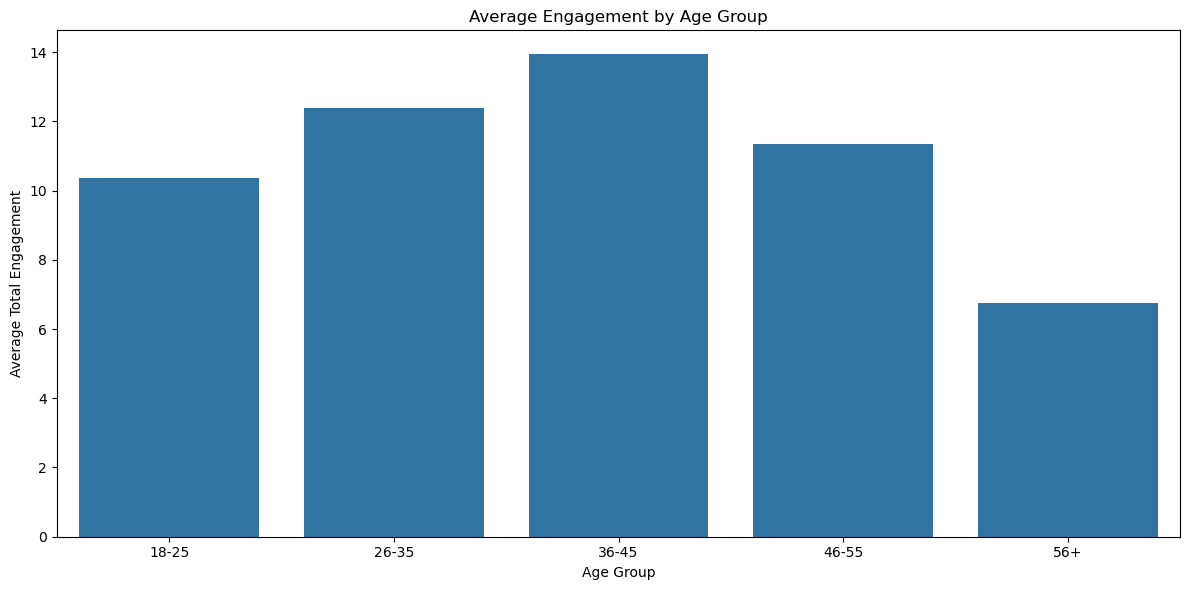

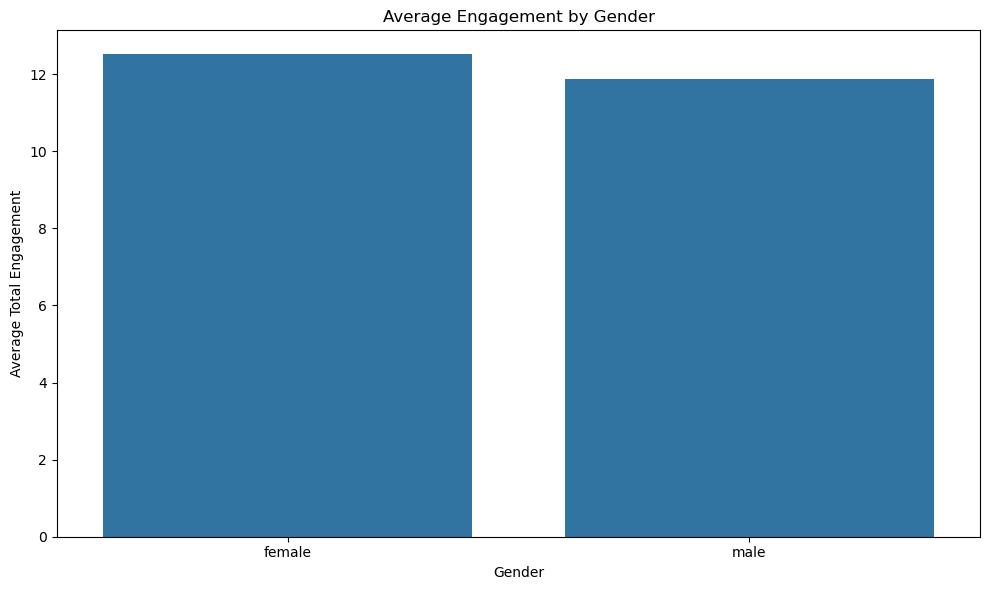

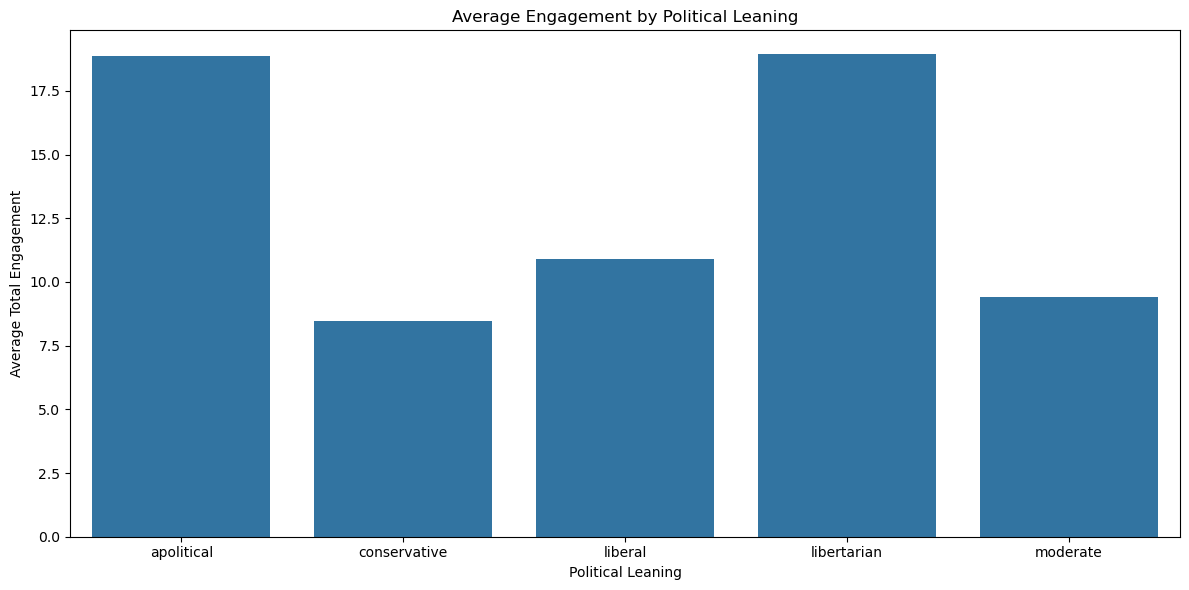

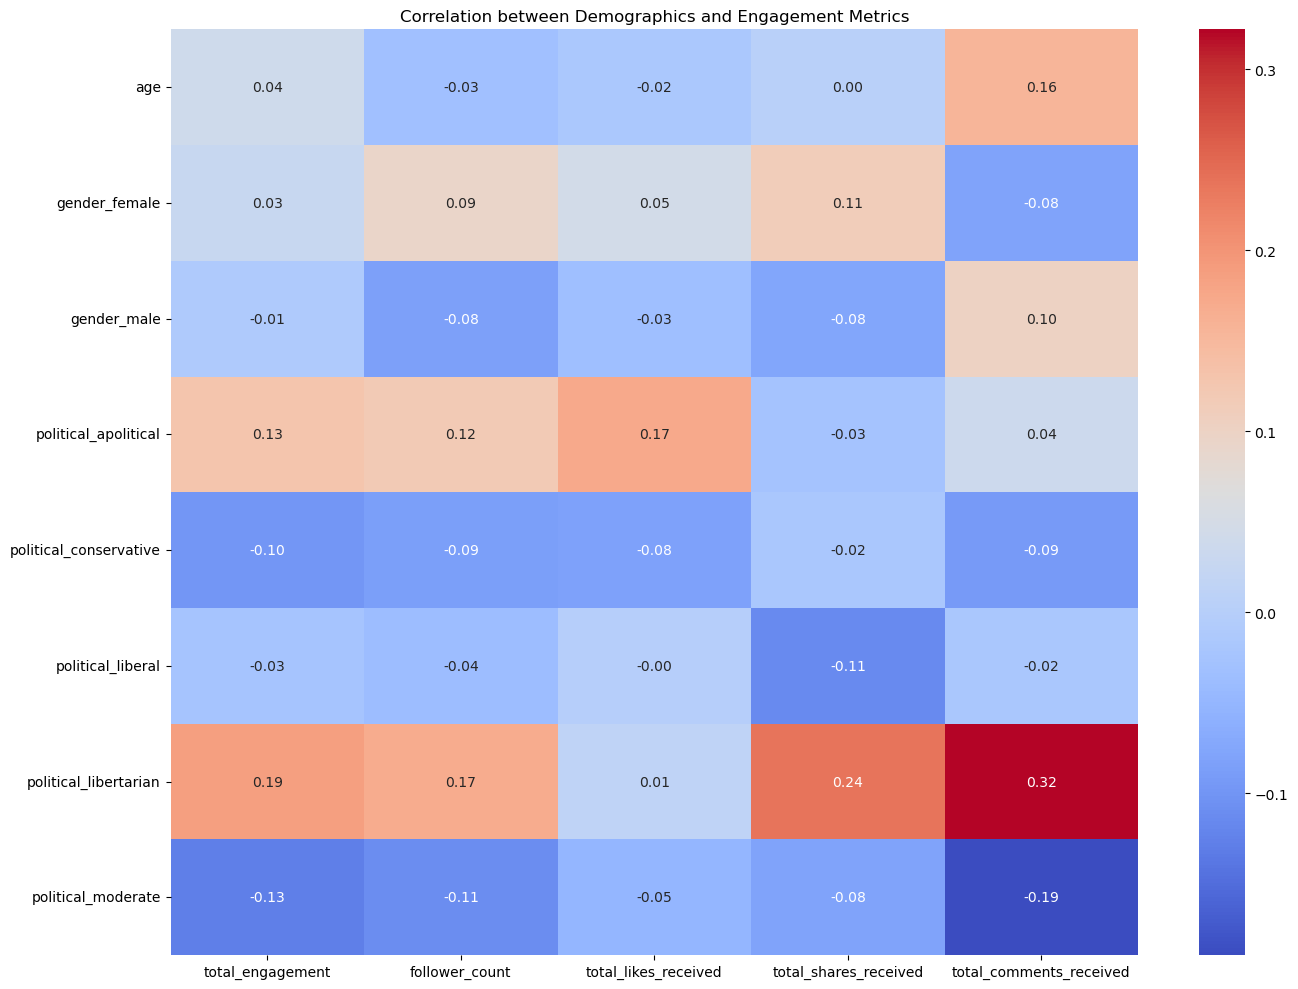

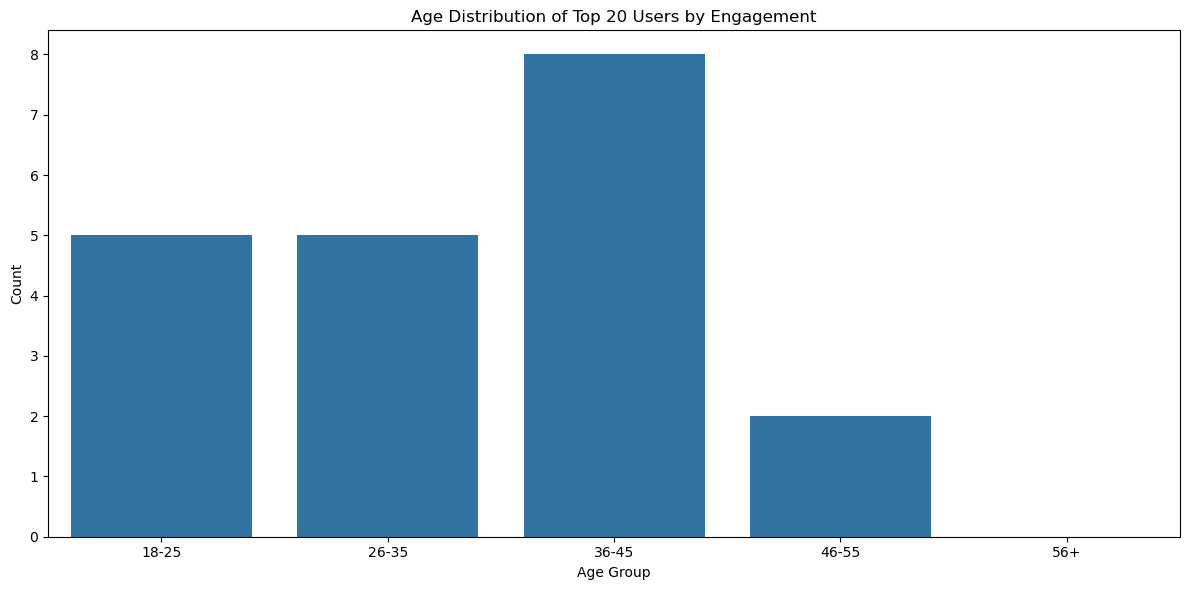

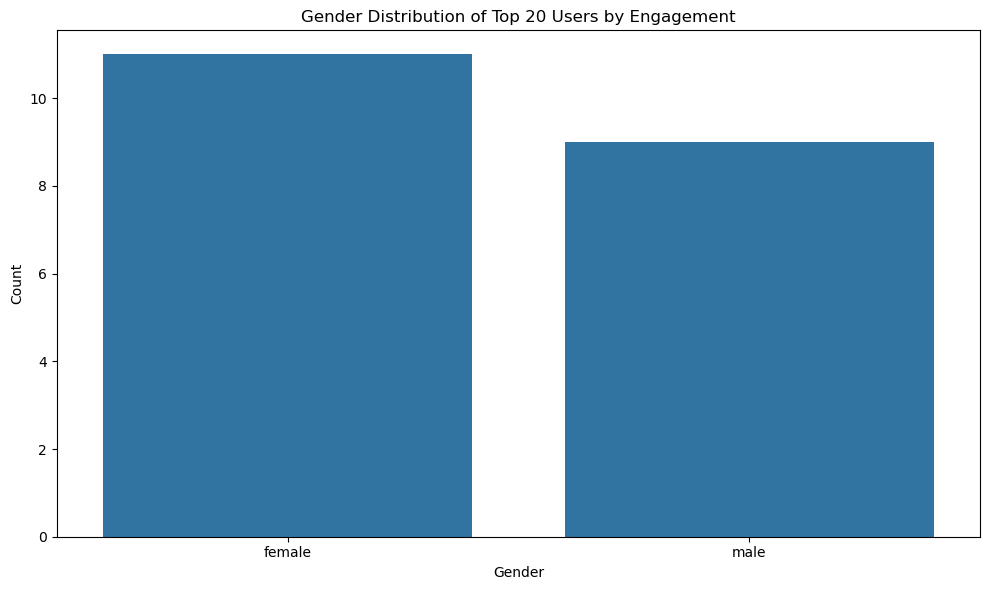

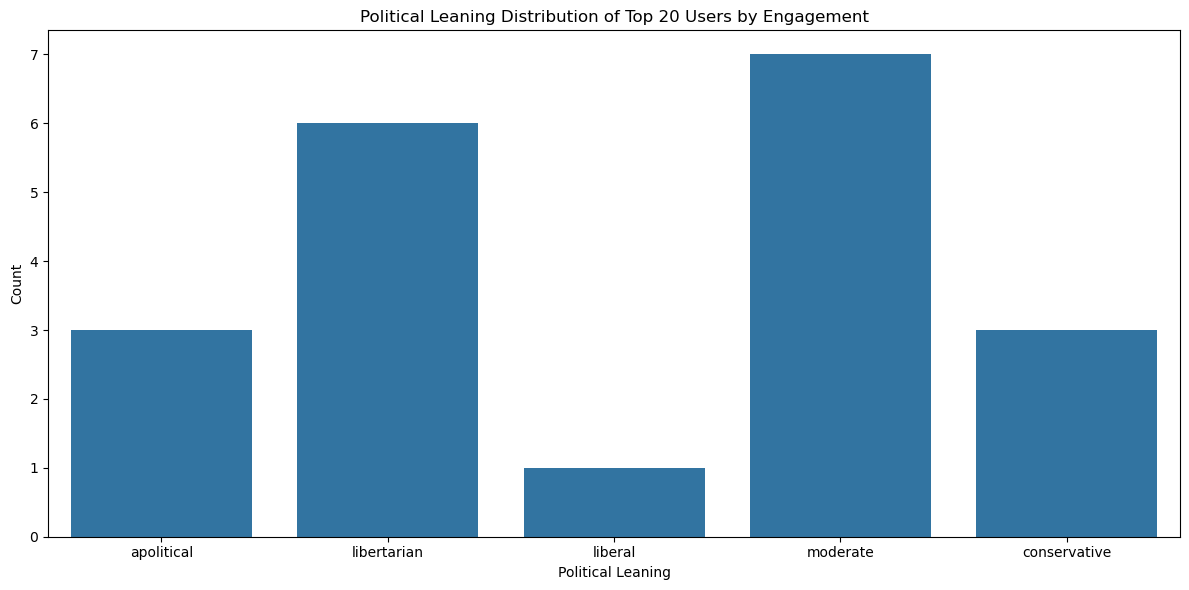

<Figure size 1400x800 with 0 Axes>

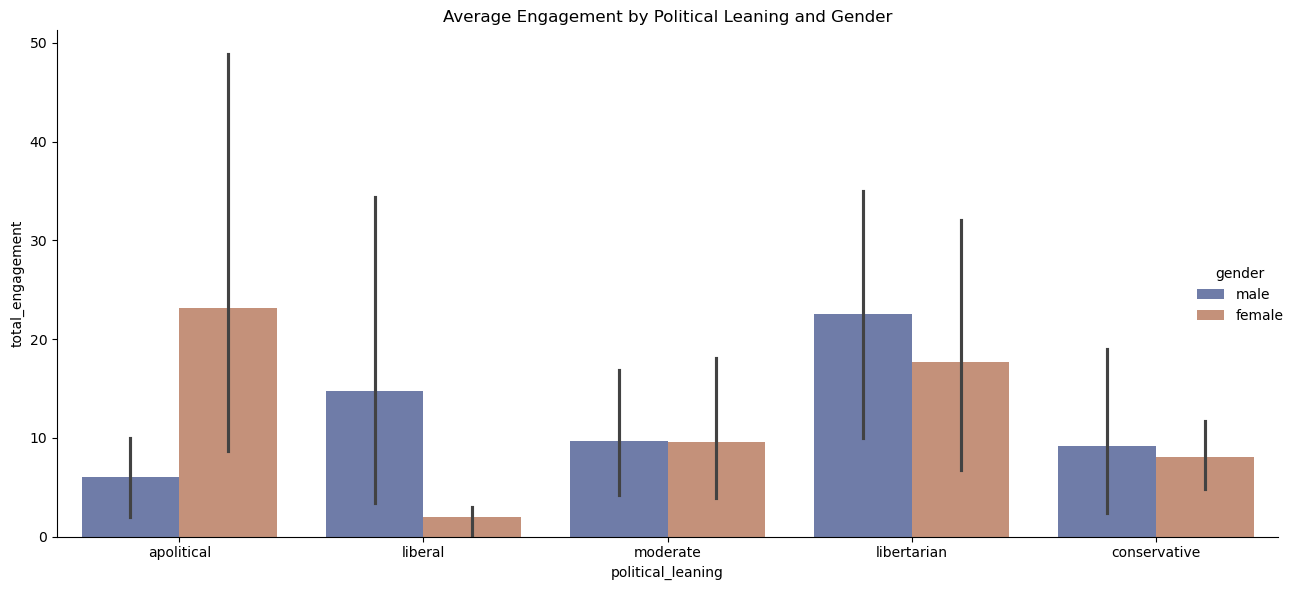

<Figure size 1400x800 with 0 Axes>

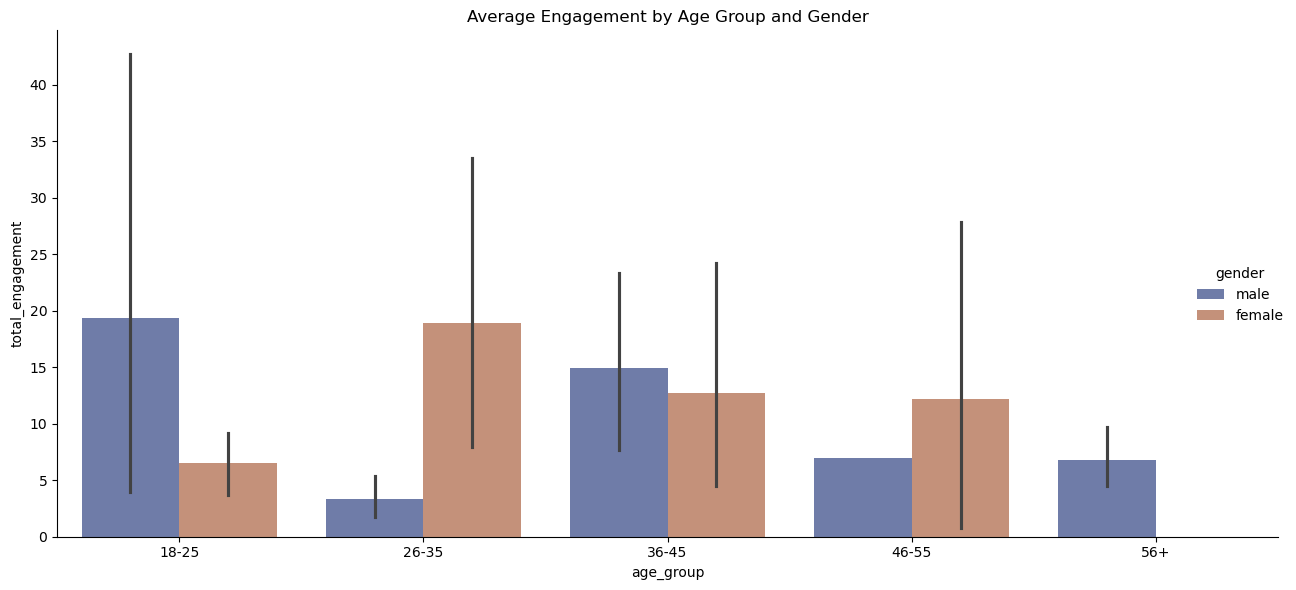


SUMMARY OF DEMOGRAPHIC CORRELATIONS WITH ENGAGEMENT:
Age correlation with engagement: 0.039
There is minimal correlation between age and engagement.

Gender with highest engagement: female (12.51)
Difference in engagement between genders: 5.3%

Political leaning with highest engagement: libertarian (18.93)

Top demographic combinations by average engagement:
1. male, liberal, age 18-25: 72.00
2. female, apolitical, age 26-35: 50.00
3. male, libertarian, age 36-45: 27.67


/tmp/ipykernel_583966/579154399.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = results['df'].groupby(['gender', 'political_leaning', 'age_group'])['total_engagement'].mean().reset_index()


In [12]:
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_demographics_and_engagement(db_name):
    """
    Analyze correlation between age, gender, political leaning and engagement metrics.
    """
    conn = sqlite3.connect(db_name)
    
    # Get all users with their engagement metrics
    query = """
    SELECT 
        user_id, 
        persona,
        follower_count,
        total_likes_received,
        total_shares_received,
        total_comments_received,
        (follower_count + total_likes_received + total_shares_received + total_comments_received) as total_engagement
    FROM users
    WHERE user_id != 'agentverse_news'
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    # Extract demographic information from persona text
    def extract_age(persona):
        match = re.search(r'You are a (\d+) year old', persona)
        if match:
            return int(match.group(1))
        return None
    
    def extract_gender(persona):
        match = re.search(r'You are a \d+ year old (male|female)', persona)
        if match:
            return match.group(1)
        return None
    
    def extract_political(persona):
        # Common political affiliations in the data
        affiliations = ['liberal', 'conservative', 'moderate', 'libertarian', 'apolitical']
        for affiliation in affiliations:
            if f"political affiliation is {affiliation}" in persona.lower():
                return affiliation
        return "unknown"
    
    # Apply extraction functions
    df['age'] = df['persona'].apply(extract_age)
    df['gender'] = df['persona'].apply(extract_gender)
    df['political_leaning'] = df['persona'].apply(extract_political)
    
    # Create age groups for better visualization
    bins = [0, 25, 35, 45, 55, 100]
    labels = ['18-25', '26-35', '36-45', '46-55', '56+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
    
    # Calculate average engagement by demographic factors
    age_engagement = df.groupby('age_group')['total_engagement'].mean().reset_index()
    gender_engagement = df.groupby('gender')['total_engagement'].mean().reset_index()
    political_engagement = df.groupby('political_leaning')['total_engagement'].mean().reset_index()
    
    # For correlation analysis, create a cleaned dataframe with only numeric and categorical data
    corr_df = df[['age', 'follower_count', 'total_likes_received', 
                 'total_shares_received', 'total_comments_received', 
                 'total_engagement']].copy()
    
    # Create dummy variables for categorical values
    gender_dummies = pd.get_dummies(df['gender'], prefix='gender')
    political_dummies = pd.get_dummies(df['political_leaning'], prefix='political')
    
    # Combine with the correlation dataframe
    corr_df = pd.concat([corr_df, gender_dummies, political_dummies], axis=1)
    
    # Compute the correlation matrix
    correlation_matrix = corr_df.corr()
    
    # Count users by demographic groups
    demo_counts = {
        'age_groups': df['age_group'].value_counts().sort_index(),
        'gender': df['gender'].value_counts(),
        'political': df['political_leaning'].value_counts()
    }
    
    return {
        'df': df,
        'age_engagement': age_engagement,
        'gender_engagement': gender_engagement,
        'political_engagement': political_engagement,
        'correlation_matrix': correlation_matrix,
        'demo_counts': demo_counts
    }

# Run the analysis
results = analyze_demographics_and_engagement('20250122_215428.db')

# Display demographic distribution in dataset
print("User Demographic Distribution:")
print("\nAge Groups:")
print(results['demo_counts']['age_groups'])
print("\nGender:")
print(results['demo_counts']['gender'])
print("\nPolitical Leaning:")
print(results['demo_counts']['political'])

# Plot age group vs. engagement
plt.figure(figsize=(12, 6))
sns.barplot(x='age_group', y='total_engagement', data=results['age_engagement'])
plt.title('Average Engagement by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Total Engagement')
plt.tight_layout()
plt.savefig('age_engagement.png')
plt.show()

# Plot gender vs. engagement
plt.figure(figsize=(10, 6))
sns.barplot(x='gender', y='total_engagement', data=results['gender_engagement'])
plt.title('Average Engagement by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Total Engagement')
plt.tight_layout()
plt.savefig('gender_engagement.png')
plt.show()

# Plot political leaning vs. engagement
plt.figure(figsize=(12, 6))
sns.barplot(x='political_leaning', y='total_engagement', data=results['political_engagement'])
plt.title('Average Engagement by Political Leaning')
plt.xlabel('Political Leaning')
plt.ylabel('Average Total Engagement')
plt.tight_layout()
plt.savefig('political_engagement.png')
plt.show()

# Create a heatmap of the correlation matrix focused on demographic factors
plt.figure(figsize=(14, 10))
# Extract relevant rows and columns
engagement_cols = ['total_engagement', 'follower_count', 'total_likes_received', 
                  'total_shares_received', 'total_comments_received']
demographic_cols = ['age'] + [col for col in results['correlation_matrix'].columns 
                             if col.startswith('gender_') or col.startswith('political_')]

# Create a focused correlation matrix
focused_corr = results['correlation_matrix'].loc[demographic_cols, engagement_cols]

# Plot the heatmap
sns.heatmap(focused_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Demographics and Engagement Metrics')
plt.tight_layout()
plt.savefig('demographics_engagement_correlation.png')
plt.show()

# Plot distribution of top users by demographics
top_users = results['df'].sort_values('total_engagement', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.countplot(x='age_group', data=top_users)
plt.title('Age Distribution of Top 20 Users by Engagement')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('top_users_age.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='gender', data=top_users)
plt.title('Gender Distribution of Top 20 Users by Engagement')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('top_users_gender.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='political_leaning', data=top_users)
plt.title('Political Leaning Distribution of Top 20 Users by Engagement')
plt.xlabel('Political Leaning')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('top_users_political.png')
plt.show()

# Save the demographic analysis to CSV
results['df'][['user_id', 'age', 'gender', 'political_leaning', 
               'follower_count', 'total_likes_received', 
               'total_shares_received', 'total_comments_received', 
               'total_engagement']].to_csv('demographic_engagement_analysis.csv', index=False)

# Additional analysis: Combined factors
# Create a combined chart showing engagement by gender and political leaning
plt.figure(figsize=(14, 8))
sns.catplot(
    data=results['df'],
    kind="bar",
    x="political_leaning", y="total_engagement", hue="gender",
    palette="dark", alpha=.6, height=6, aspect=2
)
plt.title('Average Engagement by Political Leaning and Gender')
plt.tight_layout()
plt.savefig('political_gender_engagement.png')
plt.show()

# Show engagement by age and gender
plt.figure(figsize=(14, 8))
sns.catplot(
    data=results['df'],
    kind="bar",
    x="age_group", y="total_engagement", hue="gender",
    palette="dark", alpha=.6, height=6, aspect=2
)
plt.title('Average Engagement by Age Group and Gender')
plt.tight_layout()
plt.savefig('age_gender_engagement.png')
plt.show()

# Print text summary of findings
print("\nSUMMARY OF DEMOGRAPHIC CORRELATIONS WITH ENGAGEMENT:")
print("=====================================================")

# Age correlation
age_corr = results['correlation_matrix'].loc['age', 'total_engagement']
print(f"Age correlation with engagement: {age_corr:.3f}")
if abs(age_corr) > 0.1:
    trend = "positive" if age_corr > 0 else "negative"
    print(f"There is a {trend} correlation between age and engagement.")
else:
    print("There is minimal correlation between age and engagement.")

# Gender differences
gender_data = results['gender_engagement']
if len(gender_data) > 1:
    max_gender = gender_data.loc[gender_data['total_engagement'].idxmax()]
    print(f"\nGender with highest engagement: {max_gender['gender']} ({max_gender['total_engagement']:.2f})")
    
    # Calculate percentage difference
    if len(gender_data) == 2:
        gender_diff_pct = ((gender_data.iloc[0]['total_engagement'] / gender_data.iloc[1]['total_engagement']) - 1) * 100
        print(f"Difference in engagement between genders: {abs(gender_diff_pct):.1f}%")

# Political leaning
pol_data = results['political_engagement']
max_pol = pol_data.loc[pol_data['total_engagement'].idxmax()]
print(f"\nPolitical leaning with highest engagement: {max_pol['political_leaning']} ({max_pol['total_engagement']:.2f})")

# Print top 3 demographic combinations by engagement
print("\nTop demographic combinations by average engagement:")
grouped = results['df'].groupby(['gender', 'political_leaning', 'age_group'])['total_engagement'].mean().reset_index()
top_combos = grouped.sort_values('total_engagement', ascending=False).head(3)
for i, row in enumerate(top_combos.iterrows(), 1):
    row = row[1]
    print(f"{i}. {row['gender']}, {row['political_leaning']}, age {row['age_group']}: {row['total_engagement']:.2f}")

In [7]:
import sqlite3
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

def analyze_label_correlations():
    # Connect to the database
    conn = sqlite3.connect('20250122_215428.db')
    
    # Get users with their engagement metrics and background labels
    query = """
    SELECT 
        user_id,
        background_labels,
        follower_count,
        total_likes_received,
        total_shares_received,
        total_comments_received,
        (total_likes_received + total_shares_received + total_comments_received) as total_engagement
    FROM users
    WHERE background_labels IS NOT NULL
    """
    
    df = pd.read_sql_query(query, conn)
    
    # Parse JSON background labels
    df['background_labels'] = df['background_labels'].apply(json.loads)
    
    # Create separate columns for each background label
    label_columns = [
        'age', 'gender', 'current_location', 'education_level', 'activity',
        'value', 'personality', 'social_context', 'hobby', 'political_affiliation',
        'num_places_lived', 'social_relationship_importance', 'childhood_description',
        'primary_goal', 'fear', 'meaningful_event', 'religious_beliefs',
        'difficult_situation_resolve', 'friend_value', 'income_level',
        'ethnicity', 'primary_language'
    ]
    
    for col in label_columns:
        df[col] = df['background_labels'].apply(lambda x: x.get(col))
    
    # Engagement metrics to analyze
    engagement_metrics = [
        'follower_count', 'total_likes_received', 
        'total_shares_received', 'total_comments_received',
        'total_engagement'
    ]
    
    # Create a DataFrame to store p-values
    p_values = pd.DataFrame(
        index=label_columns,
        columns=engagement_metrics,
        dtype=float
    )
    
    # Create a DataFrame to store F-statistics
    f_statistics = pd.DataFrame(
        index=label_columns,
        columns=engagement_metrics,
        dtype=float
    )
    
    # Analyze correlations for each label
    for label in label_columns:
        for metric in engagement_metrics:
            try:
                # Group data and remove any NaN values
                groups = [group[metric].dropna().values 
                         for name, group in df.groupby(label) 
                         if len(group[metric].dropna()) > 0]
                
                if len(groups) > 1 and all(len(g) > 0 for g in groups):
                    f_stat, p_value = stats.f_oneway(*groups)
                    p_values.loc[label, metric] = p_value
                    f_statistics.loc[label, metric] = f_stat
                else:
                    p_values.loc[label, metric] = np.nan
                    f_statistics.loc[label, metric] = np.nan
            except Exception as e:
                print(f"Error processing {label} vs {metric}: {str(e)}")
                p_values.loc[label, metric] = np.nan
                f_statistics.loc[label, metric] = np.nan
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    sns.heatmap(p_values, 
                annot=True, 
                cmap='RdYlBu_r',
                fmt='.3f',
                mask=p_values.isna())
    plt.title('P-values for Background Labels vs Engagement Metrics')
    plt.tight_layout()
    plt.savefig('label_correlations_p_values.png')
    plt.close()
    
    # Create heatmap for F-statistics
    plt.figure(figsize=(15, 10))
    sns.heatmap(f_statistics, 
                annot=True, 
                cmap='viridis',
                fmt='.3f',
                mask=f_statistics.isna())
    plt.title('F-statistics for Background Labels vs Engagement Metrics')
    plt.tight_layout()
    plt.savefig('label_correlations_f_stats.png')
    plt.close()
    
    # Find significant correlations (p < 0.05)
    significant_correlations = pd.DataFrame(
        p_values < 0.05,
        columns=engagement_metrics
    )
    
    return {
        'p_values': p_values,
        'f_statistics': f_statistics,
        'significant_correlations': significant_correlations,
        'raw_data': df
    }

# Run the analysis
results = analyze_label_correlations()

# Print significant findings
print("\nSignificant correlations (p < 0.05):")
for label in results['p_values'].index:
    significant_metrics = results['p_values'].loc[label][results['p_values'].loc[label] < 0.05]
    if len(significant_metrics) > 0:
        print(f"\n{label}:")
        for metric, p_value in significant_metrics.items():
            f_stat = results['f_statistics'].loc[label, metric]
            print(f"  {metric}: p-value = {p_value:.4f}, F-statistic = {f_stat:.4f}")



Significant correlations (p < 0.05):

social_relationship_importance:
  total_shares_received: p-value = 0.0491, F-statistic = 2.5029
  total_comments_received: p-value = 0.0447, F-statistic = 2.5658


In [9]:
import sqlite3
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def analyze_age_correlations():
    # Connect to the database
    conn = sqlite3.connect('20250122_215428.db')
    
    # Get users with their engagement metrics and background labels
    query = """
    SELECT 
        user_id,
        background_labels,
        follower_count,
        total_likes_received,
        total_shares_received,
        total_comments_received,
        (total_likes_received + total_shares_received + total_comments_received) as total_engagement
    FROM users
    WHERE background_labels IS NOT NULL
    """
    
    df = pd.read_sql_query(query, conn)
    
    # Parse JSON background labels and extract age
    df['age'] = df['background_labels'].apply(lambda x: int(json.loads(x)['age']))
    
    # Engagement metrics to analyze
    engagement_metrics = [
        'follower_count', 
        'total_likes_received', 
        'total_shares_received', 
        'total_comments_received',
        'total_engagement'
    ]
    
    # Calculate correlations
    pearson_correlations = {}
    spearman_correlations = {}
    
    for metric in engagement_metrics:
        # Pearson correlation
        pearson_corr, pearson_p = stats.pearsonr(df['age'], df[metric])
        pearson_correlations[metric] = {
            'correlation': pearson_corr,
            'p_value': pearson_p
        }
        
        # Spearman correlation
        spearman_corr, spearman_p = stats.spearmanr(df['age'], df[metric])
        spearman_correlations[metric] = {
            'correlation': spearman_corr,
            'p_value': spearman_p
        }
    
    # Create scatter plots for each metric
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(engagement_metrics):
        sns.scatterplot(data=df, x='age', y=metric, ax=axes[idx])
        axes[idx].set_title(f'Age vs {metric}')
        
        # Add trend line
        z = np.polyfit(df['age'], df[metric], 1)
        p = np.poly1d(z)
        axes[idx].plot(df['age'], p(df['age']), "r--", alpha=0.8)
        
        # Add correlation coefficient to plot
        corr = pearson_correlations[metric]['correlation']
        p_val = pearson_correlations[metric]['p_value']
        axes[idx].text(0.05, 0.95, 
                      f'r = {corr:.3f}\np = {p_val:.3f}',
                      transform=axes[idx].transAxes,
                      bbox=dict(facecolor='white', alpha=0.8))
    
    # Remove the extra subplot
    axes[-1].remove()
    
    plt.tight_layout()
    plt.savefig('age_correlations.png')
    plt.close()
    
    # Create age groups for additional analysis
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 25, 35, 45, 55, 100],
                            labels=['18-25', '26-35', '36-45', '46-55', '56+'])
    
    # Calculate mean engagement metrics by age group
    age_group_stats = df.groupby('age_group')[engagement_metrics].mean()
    
    # Create bar plots for age groups
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(engagement_metrics):
        sns.barplot(data=df, x='age_group', y=metric, ax=axes[idx])
        axes[idx].set_title(f'Average {metric} by Age Group')
        axes[idx].tick_params(axis='x', rotation=45)
    
    axes[-1].remove()
    plt.tight_layout()
    plt.savefig('age_group_analysis.png')
    plt.close()
    
    return {
        'pearson_correlations': pearson_correlations,
        'spearman_correlations': spearman_correlations,
        'age_group_stats': age_group_stats,
        'raw_data': df
    }

# Run the analysis
results = analyze_age_correlations()

# Print results
print("\nPearson Correlations with Age:")
for metric, stats in results['pearson_correlations'].items():
    print(f"\n{metric}:")
    print(f"  Correlation coefficient: {stats['correlation']:.4f}")
    print(f"  P-value: {stats['p_value']:.4f}")

print("\nMean Engagement Metrics by Age Group:")
print(results['age_group_stats'])

/tmp/ipykernel_627665/895465855.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_stats = df.groupby('age_group')[engagement_metrics].mean()



Pearson Correlations with Age:

follower_count:
  Correlation coefficient: -0.0330
  P-value: 0.7683

total_likes_received:
  Correlation coefficient: -0.0163
  P-value: 0.8843

total_shares_received:
  Correlation coefficient: 0.0040
  P-value: 0.9719

total_comments_received:
  Correlation coefficient: 0.1554
  P-value: 0.1632

total_engagement:
  Correlation coefficient: 0.0625
  P-value: 0.5769

Mean Engagement Metrics by Age Group:
           follower_count  total_likes_received  total_shares_received  \
age_group                                                                
18-25            3.863636              1.818182               0.818182   
26-35            3.909091              4.227273               0.863636   
36-45            3.035714              3.642857               0.892857   
46-55            4.000000              0.250000               0.625000   
56+              0.500000              0.500000               1.000000   

           total_comments_received  tot